### Introduction
In this notebook, we explore how to estimate uncertainty in neural networks using Monte Carlo (MC) Dropout.
We'll use a regression task on the California housing dataset, where the goal is to predict house prices.

MC Dropout allows us to treat dropout layers as a Bayesian approximation, providing an estimation of the model's uncertainty during inference. We'll implement this technique using PyTorch and visualize the uncertainty using standard deviation of predictions across multiple stochastic forward passes.


### Load and Preprocess the Data
We'll use the California housing dataset from `sklearn.datasets`.
After loading the dataset, we'll standardize the features and split the data into training and testing sets.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

# Load and preprocess the California housing dataset
california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


### Neural Network with Dropout
We define a fully connected neural network with dropout layers. Dropout is applied both during training and inference (using Monte Carlo Dropout) to estimate model uncertainty.


In [2]:
# Define the neural network model with dropout layers
class MC_Dropout_Net(nn.Module):
    def __init__(self, input_size):
        super(MC_Dropout_Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for uncertainty
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(0.5)  # Dropout for uncertainty
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


### Training the Model
We train the model using Mean Squared Error (MSE) loss and the Adam optimizer. We'll train it for 100 epochs and monitor the training loss.


In [3]:
# Instantiate model, loss function, and optimizer
model = MC_Dropout_Net(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, n_epochs=100):
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Create data loaders
train_dataset = data_utils.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = data_utils.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train the model
train_model(model, train_loader, criterion, optimizer, n_epochs=100)


Epoch 1/100, Loss: 1.7550
Epoch 11/100, Loss: 0.5128
Epoch 21/100, Loss: 0.4423
Epoch 31/100, Loss: 0.4047
Epoch 41/100, Loss: 0.3946
Epoch 51/100, Loss: 0.3877
Epoch 61/100, Loss: 0.3795
Epoch 71/100, Loss: 0.3718
Epoch 81/100, Loss: 0.3774
Epoch 91/100, Loss: 0.3745


### Monte Carlo Dropout for Uncertainty Estimation
We perform multiple stochastic forward passes with dropout active during inference to estimate the uncertainty in predictions.


In [7]:
# Monte Carlo Dropout - Perform T stochastic forward passes
def mc_dropout_inference(model, X_test, T=100):
    model.train()  # Keep dropout on during inference
    predictions = []
    for _ in range(T):
        preds = model(X_test).detach().numpy()
        predictions.append(preds)
    predictions = np.array(predictions)

    # Mean and standard deviation (uncertainty)
    mean_preds = np.mean(predictions, axis=0)
    uncertainty = np.std(predictions, axis=0)
    return mean_preds, uncertainty

# Perform MC Dropout inference
mean_preds, uncertainty = mc_dropout_inference(model, X_test_tensor, T=100)


### Visualize Uncertainty
We visualize the mean predictions along with their uncertainty (standard deviation) for a subset of the data.
We'll also plot the true house prices for comparison.


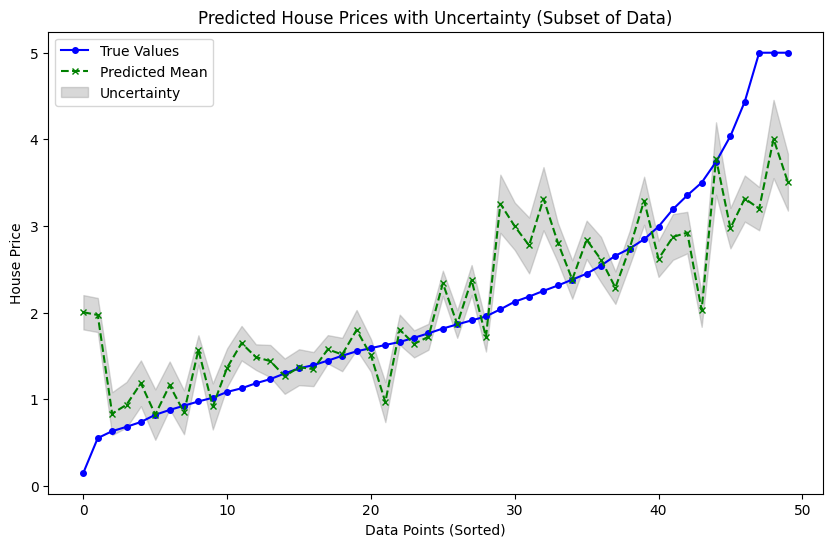

In [8]:
# Plot uncertainty for a subset of the data
def plot_uncertainty(X_test, y_test, mean_preds, uncertainty, n_points=50):
    mean_preds = mean_preds.flatten()
    uncertainty = uncertainty.flatten()
    y_test = y_test.flatten()

    sorted_indices = np.argsort(y_test)
    mean_preds = mean_preds[sorted_indices]
    uncertainty = uncertainty[sorted_indices]
    y_test = y_test[sorted_indices]

    subset_indices = np.linspace(0, len(y_test) - 1, n_points).astype(int)
    y_test_subset = y_test[subset_indices]
    mean_preds_subset = mean_preds[subset_indices]
    uncertainty_subset = uncertainty[subset_indices]

    plt.figure(figsize=(10, 6))

    plt.plot(y_test_subset, label='True Values', color='blue', marker='o', linestyle='-', markersize=4)
    plt.plot(mean_preds_subset, label='Predicted Mean', color='green', marker='x', linestyle='--', markersize=4)
    plt.fill_between(np.arange(n_points),
                     mean_preds_subset - uncertainty_subset,
                     mean_preds_subset + uncertainty_subset,
                     color='gray', alpha=0.3, label='Uncertainty')

    plt.xlabel("Data Points (Sorted)")
    plt.ylabel("House Price")
    plt.title("Predicted House Prices with Uncertainty (Subset of Data)")
    plt.legend()
    plt.show()

# Plot uncertainty
plot_uncertainty(X_test_tensor, y_test_tensor, mean_preds, uncertainty, n_points=50)


### Calculate Quantitative Uncertainty Metrics
We'll compute the mean uncertainty and the Prediction Interval Coverage Probability (PICP), which measures the proportion of true values falling within the predicted confidence intervals.


In [9]:
# Calculate quantitative uncertainty (mean uncertainty and PICP)
def calculate_uncertainty_metrics(mean_preds, uncertainty, y_test, confidence_interval=0.95):
    mean_preds = mean_preds.flatten()
    uncertainty = uncertainty.flatten()
    y_test = y_test.numpy().flatten()

    # Mean uncertainty
    mean_uncertainty = np.mean(uncertainty)

    # Confidence interval boundaries (e.g., 95%)
    z_value = 1.96  # for 95% confidence interval
    lower_bound = mean_preds - z_value * uncertainty
    upper_bound = mean_preds + z_value * uncertainty

    # PICP: Proportion of true values within the predicted confidence interval
    picp = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))

    return mean_uncertainty, picp

# Calculate and print quantitative metrics
mean_uncertainty, picp = calculate_uncertainty_metrics(mean_preds, uncertainty, y_test_tensor)

print(f"Mean Uncertainty: {mean_uncertainty}")
print(f"Prediction Interval Coverage Probability (PICP): {picp * 100:.2f}%")


Mean Uncertainty: 0.24967335164546967
Prediction Interval Coverage Probability (PICP): 71.25%
